In [1]:
import socket
import numpy as np
import matplotlib.pyplot as plt
import math

In [42]:
def le_dados_imu(N, func=None, endereco = "shaka", porta=1234):
    dd = []
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((endereco, porta))
        for i in range(N):
            data = s.recv(32)
            ax = int.from_bytes(data[0:2], byteorder='big', signed=True)
            ay = int.from_bytes(data[2:4], byteorder='big', signed=True) 
            az = int.from_bytes(data[4:6], byteorder='big', signed=True) 
            temp = int.from_bytes(data[6:8], byteorder='big', signed=True) 
            wx = int.from_bytes(data[8:10], byteorder='big', signed=True)
            wy = int.from_bytes(data[10:12], byteorder='big', signed=True)
            wz = int.from_bytes(data[12:14], byteorder='big', signed=True)
            mx = int.from_bytes(data[14:16], byteorder='big', signed=True)
            my = int.from_bytes(data[16:18], byteorder='big', signed=True)
            mz = int.from_bytes(data[18:20], byteorder='big', signed=True)
            t = int.from_bytes(data[-8:], byteorder='little', signed=False)
            dd.append([ax, ay, az, wx, wy, wz, mx, my, mz, temp, t])
            if func:
                func(i)
    return dd

Coleta 5 minutos de dados da IMU:

In [43]:
dados = le_dados_imu(5000, lambda i : print("Coletando dados: " + str(int(100*(i+1)/5000))+ "%", end="\r"))


Plota os valores puros da aceleração em z versus tempo:

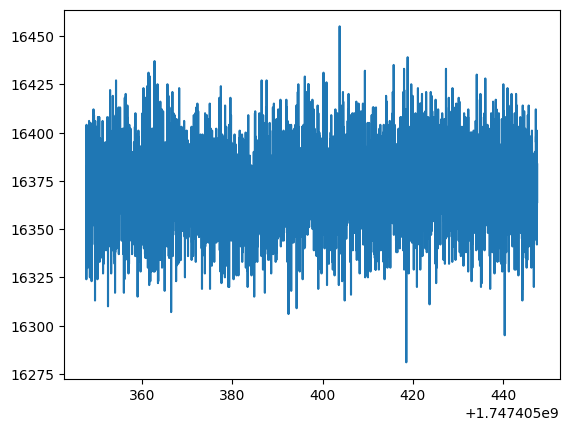

In [ ]:
# d = np.array(dados)
plt.plot(d[:,-1]*1e-9, d[:,2])

In [ ]:
#up = np . array ( dados ) [... ,0:3]
#np.savetxt("up.txt",up)

In [ ]:
#front = np . array ( dados ) [... ,0:3]
#np.savetxt("front.txt",front)

In [ ]:
#left = np . array ( dados ) [... ,0:3]
#np.savetxt("left.txt",left)

In [ ]:
#back = np . array ( dados ) [... ,0:3]
#np.savetxt("back.txt",back)

In [ ]:
#right = np.array ( dados ) [... ,0:3]
#np.savetxt("right.txt",right)

In [ ]:
#down = np.array ( dados ) [... ,0:3]
#np.savetxt("down.txt",down)

In [45]:
up = np.loadtxt("up.txt")
front = np.loadtxt("front.txt")
left = np.loadtxt("left.txt")
back = np.loadtxt("back.txt")
right = np.loadtxt("right.txt")
down = np.loadtxt("down.txt")
inclinado = np.loadtxt("inclinado.txt")

In [41]:
data = np.concatenate((up,front,left,back,right,down))
np.savetxt("todos.txt",data)

In [5]:
print(data)

[[   701.    397.  16428.]
 [   699.    390.  16411.]
 [   687.    395.  16423.]
 ...
 [   630.   1014. -16640.]
 [   663.    971. -16649.]
 [   640.    973. -16665.]]


In [9]:
scale = 0.000598

In [6]:
def costfunc1 (x , data , scale ) :
    cost = 0
    vx = x[0]
    vy = x[1]
    vz = x[2]
    g = x[3]
    for e in data:
        cost += (scale*np.sqrt((vx+e[0])**2+(vy+e[1])**2+(vz+e[2])**2)-g) ** 2
    print(x,cost)
    return cost


In [7]:
def grad_costfunc1 (x , data , scale ) :
    gradCost = np.zeros(4)
    
    vx = x[0]
    vy = x[1]
    vz = x[2]
    g = x[3]
    for e in data:
        Ri = np.sqrt((vx+e[0])**2+(vy+e[1])**2+(vz+e[2])**2)
        for i in range(3):
            gradCost[i] += 2*scale*((x[i]+e[i])/Ri)*(scale*Ri-g)
        gradCost[3] -= 2*(scale*Ri-g)
    #print(RiMin)
    return gradCost

In [10]:
print(costfunc1([0,0,0,9.8],data,scale))
print(grad_costfunc1([0,0,0,9.8],data,scale))

[0, 0, 0, 9.8] 339.18040560054885
339.18040560054885
[ 1.31031510e+00  1.05492207e+00 -7.99586490e-01 -1.98006574e+03]


In [11]:
import scipy

In [12]:
res1 = scipy.optimize.minimize ( costfunc1 , [0.0 , 0.0 , 0.0 , 9.8] , (data , scale ) , jac = grad_costfunc1 )
print ( res1 )


[0.  0.  0.  9.8] 339.18040560054885
[-6.68370566e-04 -5.38098707e-04  4.07856154e-04  1.08099996e+01] 28942.28715955177
[-2.18386034e-05 -1.75820493e-05  1.33264528e-05  9.83300112e+00] 306.5081794697832
[-1.28365939 -1.03202444  0.78414321  9.83296576] 303.1919312193473
[-6.4182096  -5.16005189  3.92066275  9.83282432] 290.15438875584334
[-26.95641045 -21.67216167  16.46674089   9.83225856] 241.6439547620427
[-85.9615052  -69.12695753  52.52560797   9.83067925] 134.673062876081
[-187.60716422 -150.91908657  114.68171993    9.82830311] 63.29151588447192
[-187.49087876 -150.8680745   114.64848594    9.82871332] 63.28485307447919
[-187.44591822 -150.8874828   114.67046477    9.82877741] 63.282892287224165
[-187.36410801 -150.9341555   114.72057249    9.82883944] 63.27908749182067
[-187.03686718 -151.12084628  114.92100335    9.82908754] 63.266988156007486
[-186.24506208 -151.63521069  115.46182648    9.82938636] 63.24179046504534
[-184.83300646 -152.6340495   116.49916178    9.82952645]

In [13]:
def calc_accel1(medida, parametros, sacle):
    rx,ry,rz=medida
    rx+=parametros[0]
    ry+=parametros[1]
    rz+=parametros[2]
    return scale*np.sqrt(rx*rx+ry*ry+rz*rz)

In [14]:
medidas_g =[calc_accel1(m,res1.x,scale) for m in data]

(array([5.000e+00, 2.500e+01, 2.190e+02, 1.072e+03, 2.583e+03, 3.912e+03,
        4.104e+03, 4.058e+03, 2.794e+03, 9.990e+02, 2.020e+02, 2.500e+01,
        3.000e+00, 2.000e+00, 8.000e+00, 3.100e+01, 1.600e+02, 5.260e+02,
        1.167e+03, 1.941e+03, 2.287e+03, 1.898e+03, 1.205e+03, 5.320e+02,
        1.870e+02, 4.300e+01, 9.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([9.75342775, 9.76015886, 9.76688996, 9.77362107, 9.78035218,
        9.78708329, 9.7938144 , 9.8005455 , 9.80727661, 9.81400772,
        9.82073883, 9.82746993, 9.83420104, 9.84093215, 9.84766326,
        9.85439436, 9.86112547, 9.86785658, 9.87458769, 9.88131879,
        9.8880499 , 9.89478101, 9.90151212, 9.90824322, 9.91497433,
        9.92170544, 9.92843655, 9.93516765, 9.94189876, 9.94862987,
        9.95536098]),
 <BarContainer object of 30 artists>)

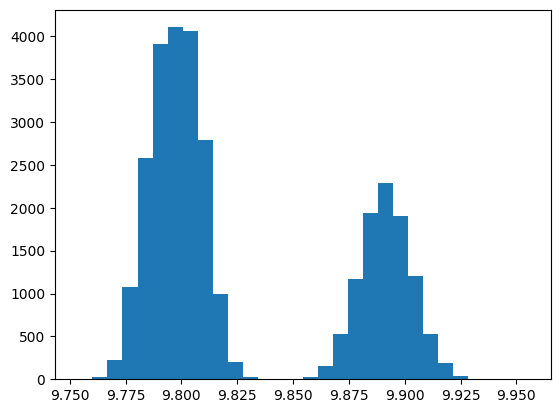

In [15]:
plt.hist(medidas_g,bins=30)

In [16]:
medidas_g_separadas = g_measures_split = [[ calc_accel1 (m , res1.x ,scale ) for m in leitura ] for leitura in [up , down , left , right , front ,back ]]

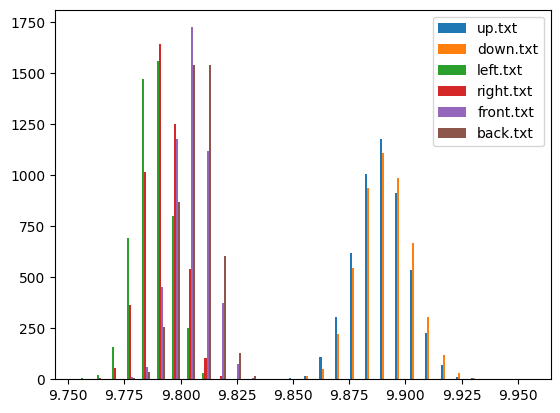

In [17]:
fig , ax = plt . subplots ()
ax . hist ( medidas_g_separadas , bins =30 , label = ("up.txt","down.txt","left.txt","right.txt","front.txt","back.txt") )
ax . legend ()

In [18]:
def Ri(xi,yi,zi,vx,vy,vz,sx,sy,sz):
    return np.sqrt((sx*(vx+xi))**2+(sy*(vy+yi))**2+(sz*(vz+zi))**2)

In [28]:
def costfunc2 (x , data , g , sc ):
    cost = 0
    for e in data:
        r= Ri(e[0],e[1],e[2],x[0],x[1],x[2],x[3],x[4],x[5])
        cost += (sc*r-g) ** 2
    print(x,cost)
    return cost

def grad_costfunc2 (x , data , g , sc ) :    
    gradCost = np.zeros(6)
    vx, vy, vz, sx, sy, sz = x

    

    for e in data:
        dx = vx + e[0]
        dy = vy + e[1]
        dz = vz + e[2]
        r =Ri(e[0],e[1],e[2],vx, vy, vz, sx, sy, sz)
        if r < 1e-12:
            r = 1e-12
        gradCost[0] += 2 * sc * (sx**2 * dx / r) * (sc * r - g)
        gradCost[1] += 2 * sc * (sy**2 * dy / r) * (sc * r - g)
        gradCost[2] += 2 * sc * (sz**2 * dz / r) * (sc * r - g)
        gradCost[3] += 2 * sc * (sx * dx**2 / r) * (sc * r - g)
        gradCost[4] += 2 * sc * (sy * dy**2 / r) * (sc * r - g)
        gradCost[5] += 2 * sc * (sz * dz**2 / r) * (sc * r - g)

    #print(RiMin)
    return gradCost

In [46]:
res2 = scipy.optimize.minimize (costfunc2, [res1.x[0], res1.x[1], res1.x[2], 1.0, 1.0, 1.0], (data, 9.786366, 0.000598), jac = grad_costfunc2, method='BFGS', tol = 1e-4)
print ( res2 )
np.savetxt("res2x.txt",res2.x)

[-183.65558781 -153.62265773  117.58701601    1.            1.
    1.        ] 116.96830605764163
[-1.83655589e+02 -1.53622659e+02  1.17587017e+02  8.25003662e-01
  9.68292477e-01  5.78125418e-03] 908154.6637861512
[-183.65558781 -153.62265773  117.58701601    0.99922639    0.99985983
    0.99560481] 42.14530907607065
[-183.65537491 -153.62241915  117.58721786    0.60936002    2.39121313
    1.01254274] 1988318.2261628874
[-183.65558781 -153.62265772  117.58701602    0.99921156    0.99991274
    0.99560546] 42.14242887523809
[-183.65558669 -153.62265646  117.5870171     0.99923722    0.9999201
    0.99560023] 42.13732125365297
[-183.6555847  -153.62265423  117.58701903    0.99923706    0.99992007
    0.99559941] 42.127004531980326
[-183.65557676 -153.62264529  117.58702673    0.99923643    0.99991995
    0.99559615] 42.08575112387403
[-183.65554499 -153.62260955  117.58705754    0.99923391    0.99991946
    0.99558309] 41.920953148812
[-183.65541792 -153.62246657  117.58718076    0.999

In [38]:
def calc_accel2 ( medida , parametros , scale ):
    rx, ry, rz = medida
    rx = parametros [3]*(rx + parametros[0])
    ry = parametros [4]*(ry + parametros[1])
    rz = parametros [5]*(rz + parametros[2])
    return scale * np.sqrt(rx * rx + ry * ry + rz * rz)

In [39]:
medidas_g2 = [calc_accel2 (m , res2.x , 0.000598) for m in data]

(array([2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 8.000e+00,
        1.800e+01, 4.200e+01, 1.440e+02, 3.590e+02, 7.450e+02, 1.677e+03,
        2.975e+03, 4.548e+03, 5.485e+03, 5.298e+03, 3.870e+03, 2.469e+03,
        1.341e+03, 5.850e+02, 2.590e+02, 1.050e+02, 4.100e+01, 1.400e+01,
        8.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([9.72572711, 9.72981539, 9.73390367, 9.73799195, 9.74208023,
        9.74616851, 9.75025679, 9.75434506, 9.75843334, 9.76252162,
        9.7666099 , 9.77069818, 9.77478646, 9.77887473, 9.78296301,
        9.78705129, 9.79113957, 9.79522785, 9.79931613, 9.8034044 ,
        9.80749268, 9.81158096, 9.81566924, 9.81975752, 9.8238458 ,
        9.82793408, 9.83202235, 9.83611063, 9.84019891, 9.84428719,
        9.84837547]),
 <BarContainer object of 30 artists>)

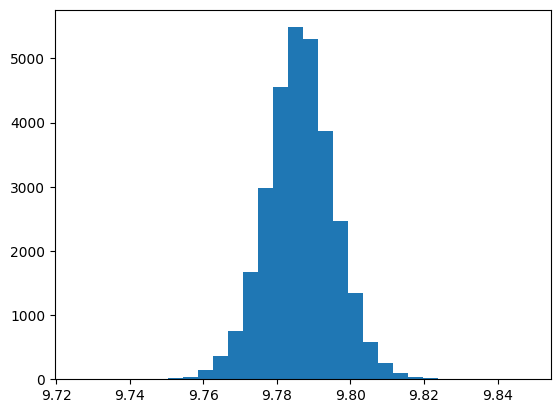

In [40]:
plt . hist ( medidas_g2 , bins =30)
